In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Tieuluan2024'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Tieuluan2024


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



In [3]:
df = pd.read_csv('imputed_bejing_saits_new.csv')
df['time'] =pd.to_datetime(df.time,format="%Y-%m-%d %H:%M:%S")
df.head()

,Unnamed: 0,station,time,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,0,Aotizhongxin,2013-03-01 00:00:00,4.000001,4.000002,4.0,6.999998,300.00003,77.0,-0.700000,1023.0,-18.800001,-8.949743e-10,6.0,4.4
1,1,Aotizhongxin,2013-03-01 01:00:00,8.000002,8.000002,4.0,6.999998,300.00003,77.0,-1.099999,1023.2,-18.199999,-8.949743e-10,3.0,4.7
2,2,Aotizhongxin,2013-03-01 02:00:00,7.000001,7.000002,5.0,9.999998,300.00003,73.0,-1.099999,1023.5,-18.199999,-8.949743e-10,6.0,5.6
3,3,Aotizhongxin,2013-03-01 03:00:00,6.000001,5.999995,11.0,10.999998,300.00003,72.0,-1.400000,1024.5,-19.400000,-8.949743e-10,7.0,3.1
4,4,Aotizhongxin,2013-03-01 04:00:00,3.000002,3.000002,12.0,12.000002,300.00003,72.0,-2.000001,1025.2,-19.500000,-8.949743e-10,3.0,2.0


In [4]:
# Lấy giá trị từ DataFrame

#
data = df
data.index = data['time']
data =  data.drop('station',axis=1)
data=  data.drop('time',axis=1)
data =  data.drop('Unnamed: 0',axis=1)


values = data.values
values_non= values

In [5]:
num_dimensions = df.shape[1]
print(f"Số chiều của dữ liệu: {num_dimensions}")

# Độ dày của dữ liệu (số lượng mẫu)
data_density = len(data)
print(f"Độ dày của dữ liệu: {data_density}")

# Tính khối lượng dữ liệu (dung lượng bộ nhớ)
data_size_bytes = data.memory_usage(deep=True).sum()
data_size_mb = data_size_bytes / (1024 * 1024)
print(f"Khối lượng dữ liệu: {data_size_mb:.2f} MB")

# Tính cấu trúc của dữ liệu (kiểm tra các cột có dữ liệu không bị thiếu)
missing_values = data.isnull().sum().sum()
if missing_values > 0:
    print("Dữ liệu không có cấu trúc đầy đủ")
else:
    print("Dữ liệu có cấu trúc đầy đủ")

# Sự tương quan và phụ thuộc (correlation matrix)
correlation_matrix = data.corr()
print("Ma trận tương quan:")
print(correlation_matrix)

# Độ nhiễu của dữ liệu (tính toán số lượng ngoại lệ)
from scipy.stats import zscore
outliers_count = (np.abs(zscore(data)) > 3).sum()  # Số lượng ngoại lệ khi z-score lớn hơn 3
print(f"Số lượng ngoại lệ trong dữ liệu: {outliers_count}")
# Sử dụng Interquartile Range (IQR) để phát hiện ngoại lệ
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum().sum()
print(f"Số lượng ngoại lệ (theo IQR): {outliers}")

Số chiều của dữ liệu: 15
Độ dày của dữ liệu: 420768
Khối lượng dữ liệu: 41.73 MB
Dữ liệu có cấu trúc đầy đủ
Ma trận tương quan:
          PM2.5      PM10       SO2       NO2        CO        O3      TEMP  \
PM2.5  1.000000  0.884318  0.482951  0.666387  0.787463 -0.151353 -0.131989   
PM10   0.884318  1.000000  0.464547  0.650913  0.701868 -0.112931 -0.096480   
SO2    0.482951  0.464547  1.000000  0.498388  0.528389 -0.166778 -0.322039   
NO2    0.666387  0.650913  0.498388  1.000000  0.700572 -0.470975 -0.275732   
CO     0.787463  0.701868  0.528389  0.700572  1.000000 -0.308006 -0.321911   
O3    -0.151353 -0.112931 -0.166778 -0.470975 -0.308006  1.000000  0.594045   
TEMP  -0.131989 -0.096480 -0.322039 -0.275732 -0.321911  0.594045  1.000000   
PRES   0.020230 -0.017470  0.224045  0.174022  0.187207 -0.445348 -0.813309   
DEWP   0.113511  0.069281 -0.267356 -0.030161 -0.056818  0.310797  0.820257   
RAIN  -0.014593 -0.026534 -0.040248 -0.043788 -0.013046  0.023915  0.037658   
wd 

Số lượng ngoại lệ trong dữ liệu: PM2.5    7621
PM10     6647
SO2      9776
NO2      4371
CO       9401
O3       7075
TEMP        0
PRES        6
DEWP        1
RAIN     2411
wd          0
WSPM     7552
dtype: int64


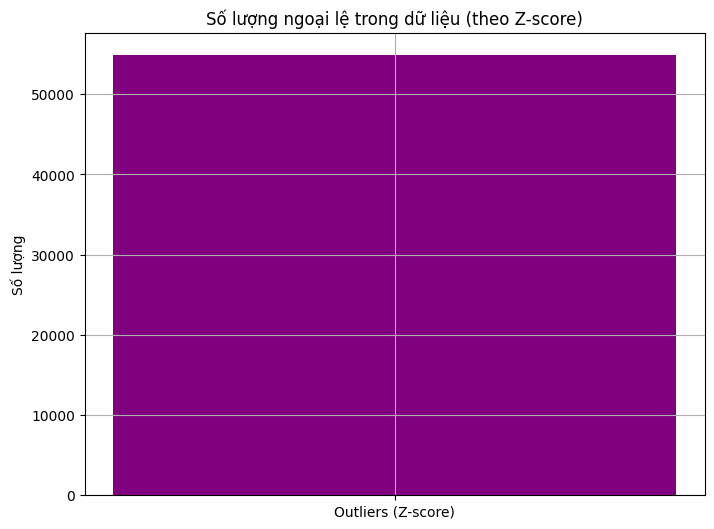

In [8]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
outliers_count = (np.abs(zscore(data)) > 3).sum()  # Số lượng ngoại lệ khi z-score lớn hơn 3
print(f"Số lượng ngoại lệ trong dữ liệu: {outliers_count}")

total_outliers = outliers_count.sum() # Calculate the total number of outliers

plt.figure(figsize=(8, 6))
plt.bar(['Outliers (Z-score)'], [total_outliers], color='purple') # Pass the total number of outliers
plt.title('Số lượng ngoại lệ trong dữ liệu (theo Z-score)')
plt.ylabel('Số lượng')
plt.grid(True)
plt.show()

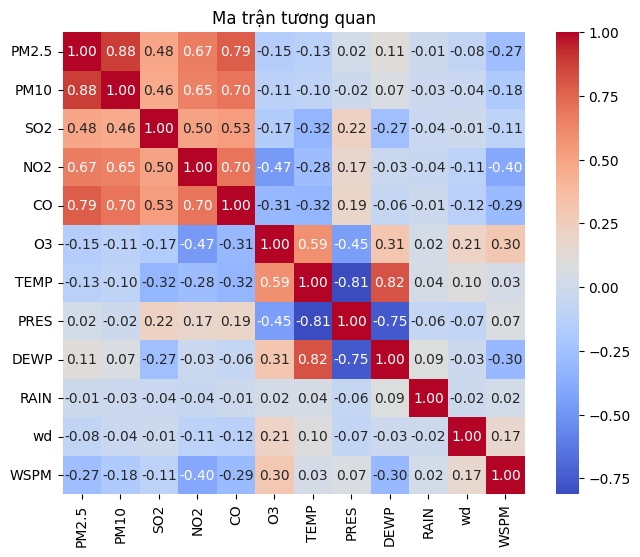

In [9]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, cbar=True, fmt='.2f', annot_kws={'size': 10})
plt.title('Ma trận tương quan')
plt.show()



In [10]:

# Chuẩn hóa dữ liệu vào khoảng [0, 1]
scalers = {}
for column in data.columns:
    scaler = MinMaxScaler()
    data[column] = scaler.fit_transform(data[[column]])
    scalers[column] = scaler


In [11]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Đặt độ dài chuỗi
SEQ_LENGTH = 50

# Tạo dữ liệu đầu vào và đầu ra cho LSTM
X, y = create_sequences(data, SEQ_LENGTH)


In [12]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [13]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=y.shape[1]))

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
#


In [14]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
8415/8415 [==============================] - 540s 64ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 2/20
8415/8415 [==============================] - 523s 62ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 3/20
8415/8415 [==============================] - 524s 62ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 4/20
8415/8415 [==============================] - 511s 61ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 5/20
8415/8415 [==============================] - 522s 62ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 6/20
8415/8415 [==============================] - 523s 62ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 7/20
8415/8415 [==============================] - 525s 62ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 8/20
8415/8415 [==============================] - 529s 63ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 9/20
8415/8415 [==============================] - 524s 62ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 10/20
8415/8415 [==============================] 

In [15]:
print('trainX shape == {}.'.format(X_train.shape))
print('trainX shape == {}.'.format(X_test.shape))
trainX_rf = X_train[:, -1, :]
testX_rf = X_test[:, -1, :]

print('trainX_rf shape == {}.'.format(trainX_rf.shape))
print('trainX_rf shape == {}.'.format(testX_rf.shape))


# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
#Xtrain_rf,ytrain_rf = df.iloc[:-n_test]  # 80% dữ liệu đầu để huấn luyện
#test_data = df.iloc[-n_test:]   # 20% dữ liệu cuối để kiểm tra

trainX shape == (336574, 50, 12).
trainX shape == (84144, 50, 12).
trainX_rf shape == (336574, 12).
trainX_rf shape == (84144, 12).


In [16]:
from sklearn.ensemble import RandomForestRegressor
rfe =RandomForestRegressor(n_estimators=100, random_state=1)
history2 = rfe.fit(trainX_rf, y_train)

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics import mean_absolute_percentage_error


y_pred = model.predict(X_test)
y_pred2 = rfe.predict(testX_rf)
# Đảo ngược chuẩn hóa cho y_test và y_pred và y_pred2
for i, column in enumerate(data.columns):
    y_test[:, i] = scalers[column].inverse_transform(y_test[:, i].reshape(-1, 1)).reshape(-1)
    y_pred[:, i] = scalers[column].inverse_transform(y_pred[:, i].reshape(-1, 1)).reshape(-1)
    y_pred2[:, i] = scalers[column].inverse_transform(y_pred2[:, i].reshape(-1, 1)).reshape(-1)

R2_lstm = r2_score(y_test, y_pred)
RMSE_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
mae_lstm = np.mean(np.abs(y_pred - y_test))

R2_rf = r2_score(y_test, y_pred2)
RMSE_rf = np.sqrt(mean_squared_error(y_test, y_pred2))
mae_rf = np.mean(np.abs(y_pred2 - y_test))

print("Mean Absolute Error (MAE):", mae_lstm)
print("Mean Squared Error (RMSE):", RMSE_lstm)
print("R2 Score:", R2_lstm)

print("Mean Absolute Error (MAE):", mae_rf)
print("Mean Squared Error (RMSE):", RMSE_rf)
print("R2 Score:", R2_rf)


2630/2630 [==============================] - 49s 18ms/step
Mean Absolute Error (MAE): 19.576499748351434
Mean Squared Error (RMSE): 95.02289100121654
R2 Score: 0.8236775333142138
Mean Absolute Error (MAE): 23.152918795625148
Mean Squared Error (RMSE): 110.56419210171238
R2 Score: 0.8477564989765983


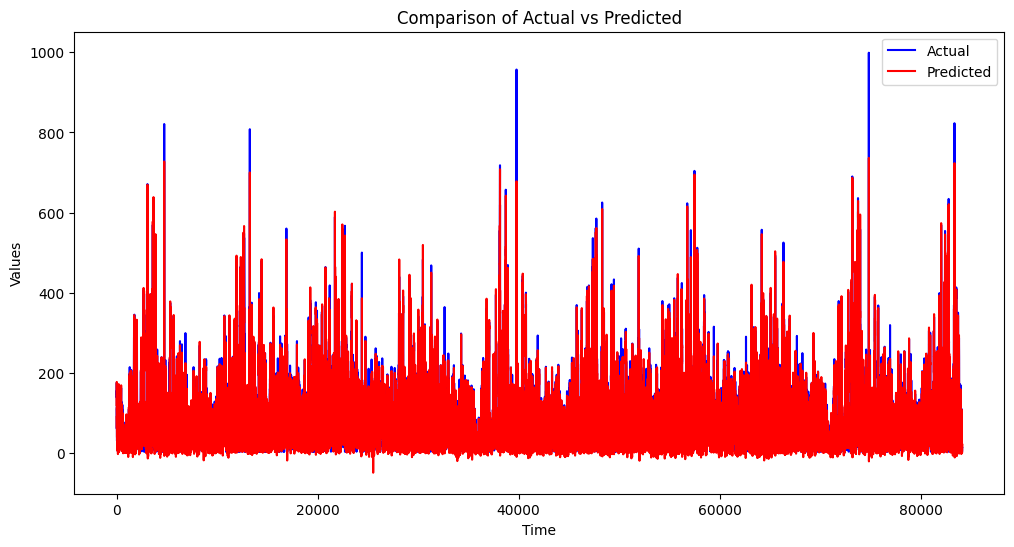

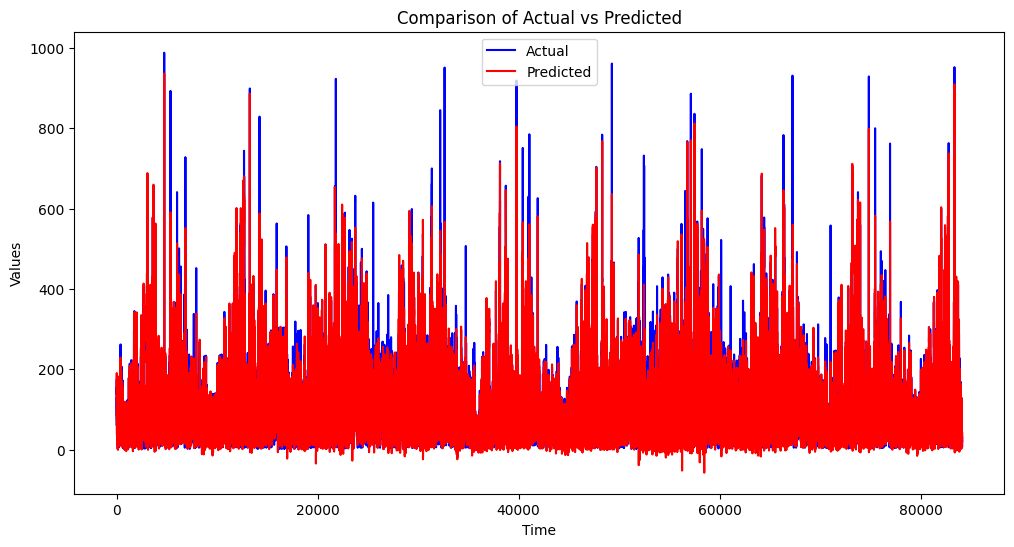

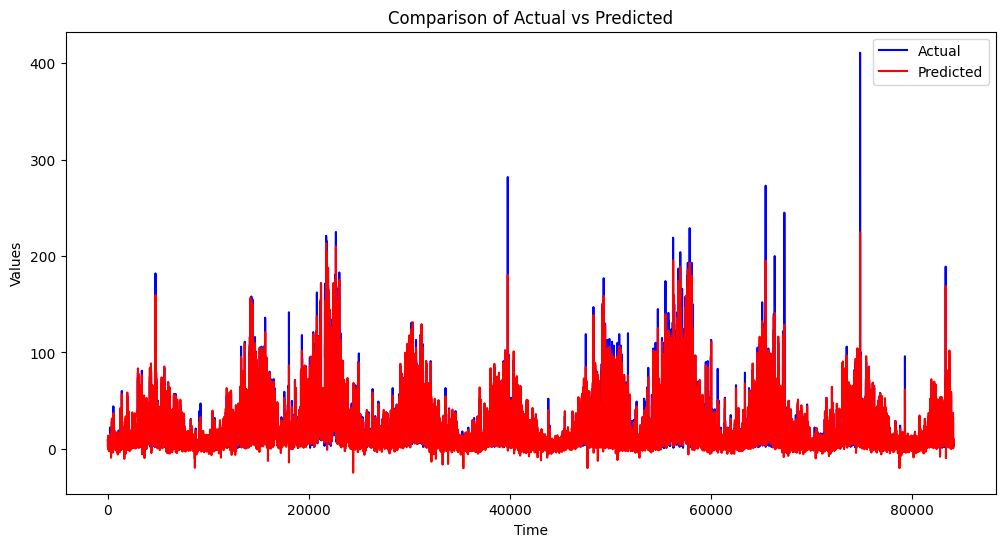

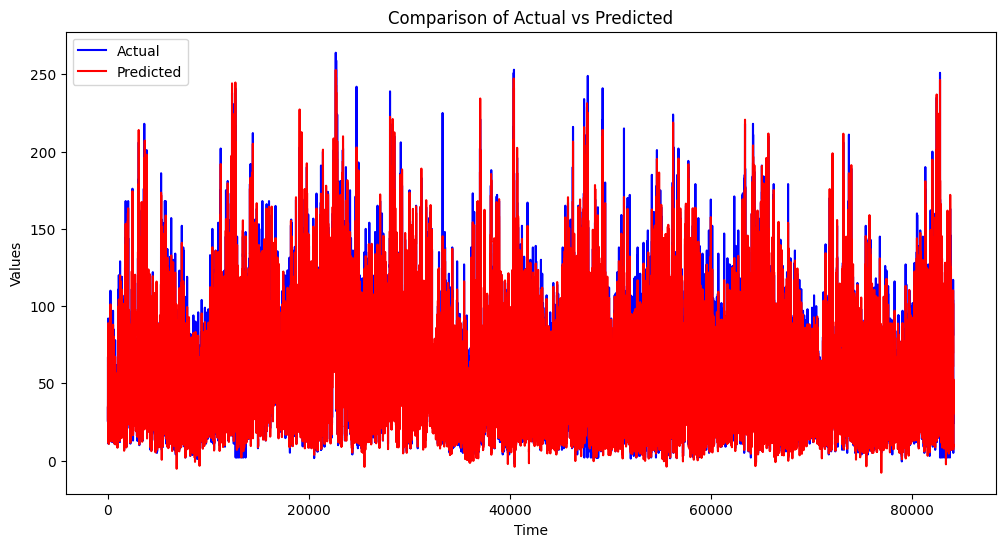

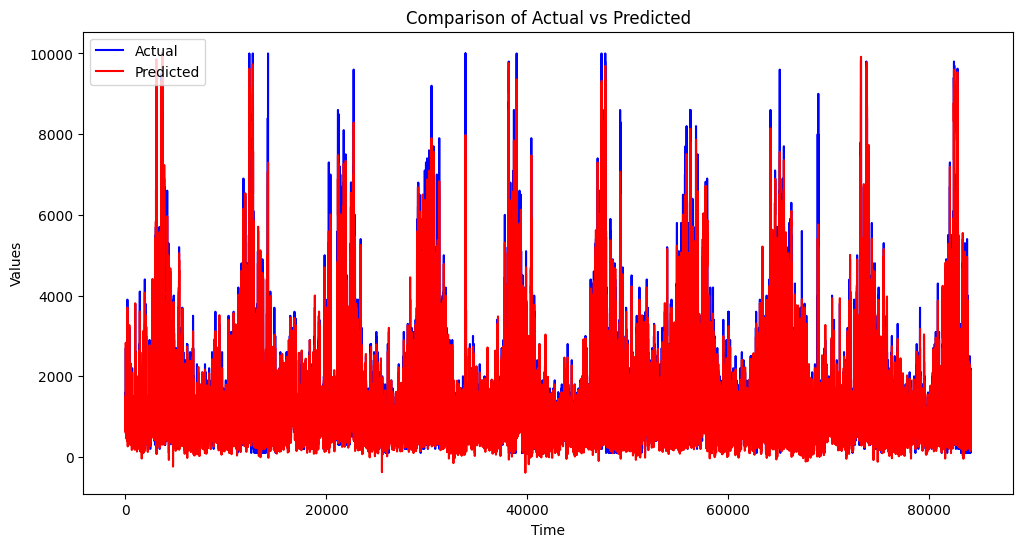

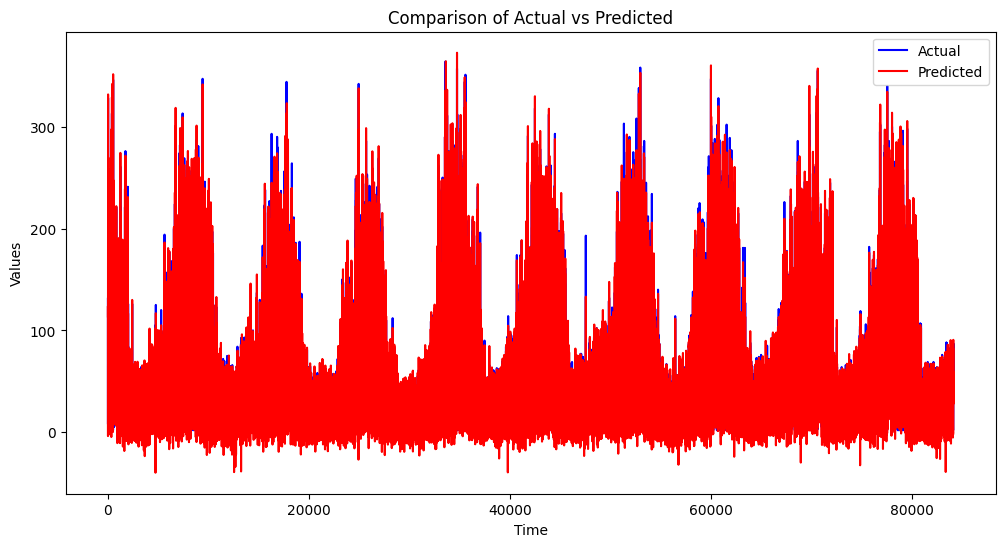

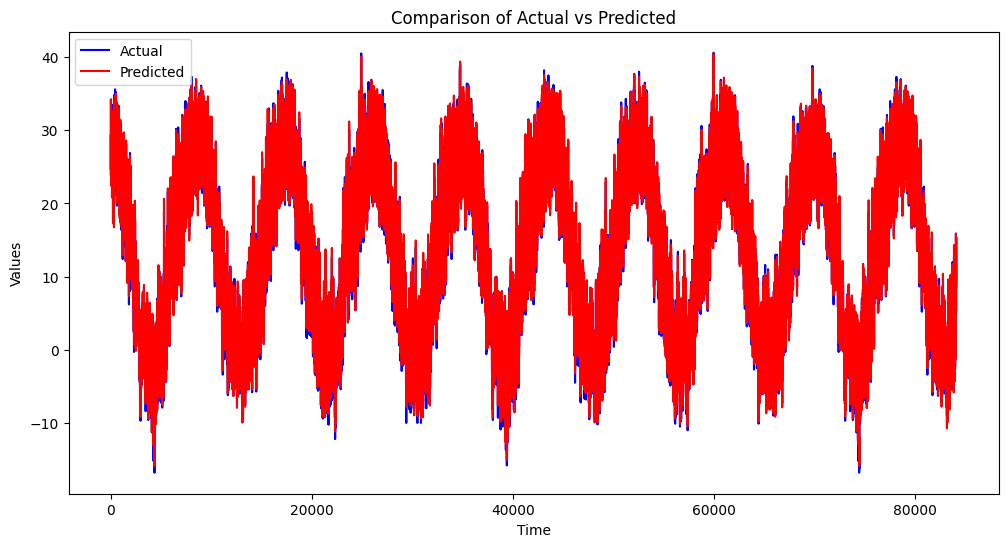

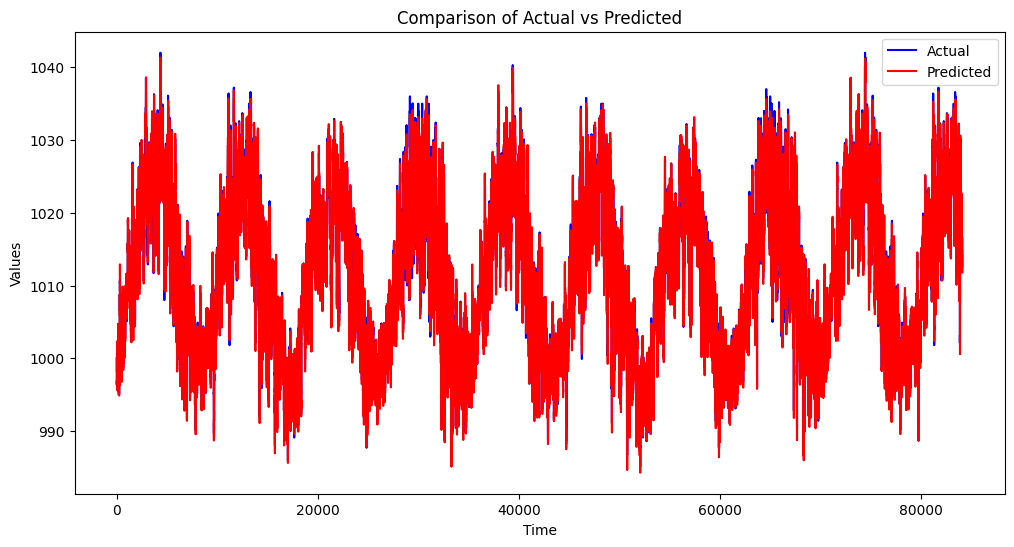

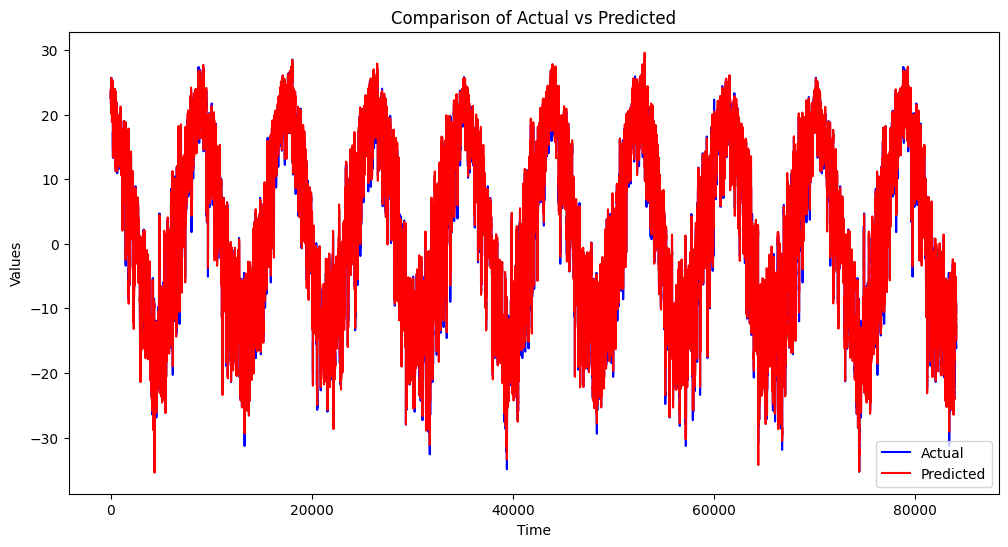

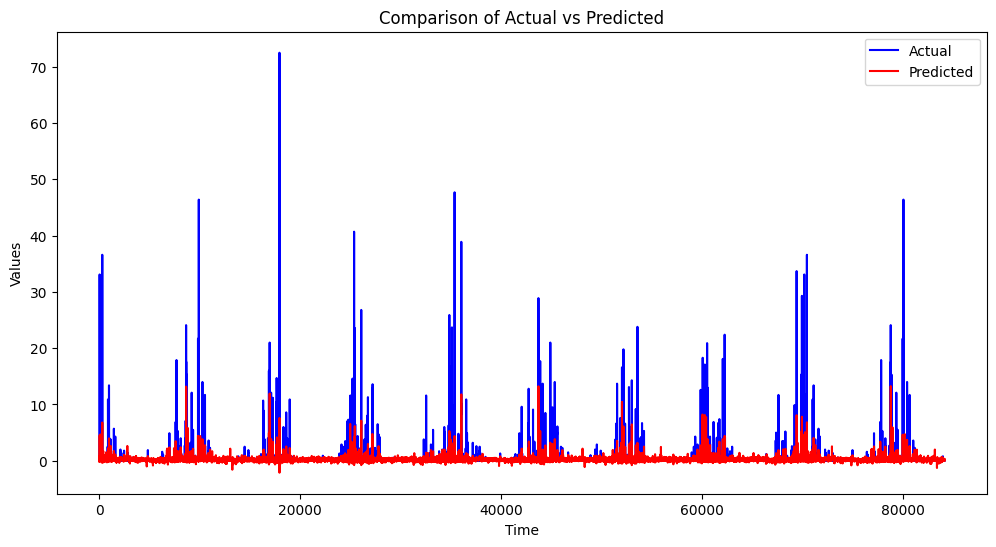

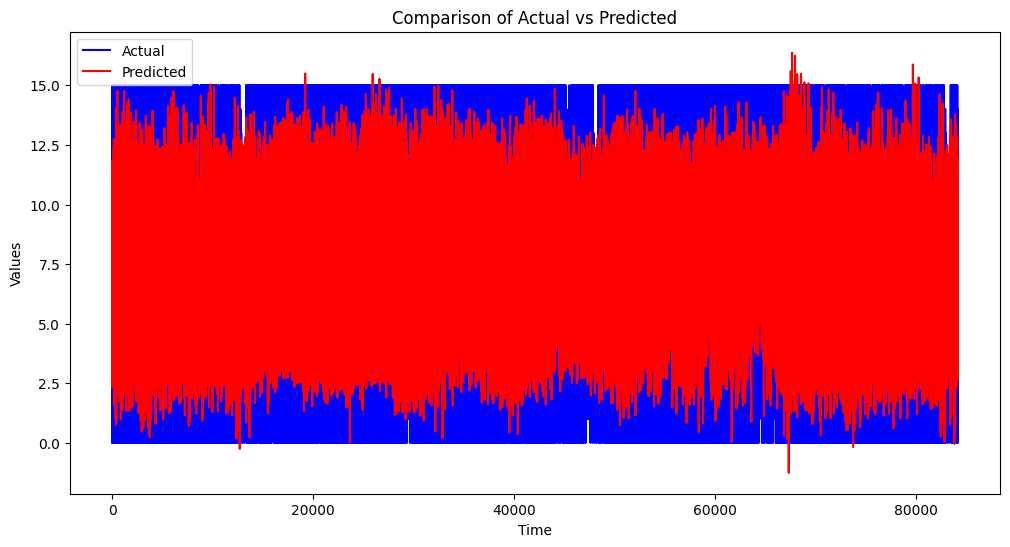

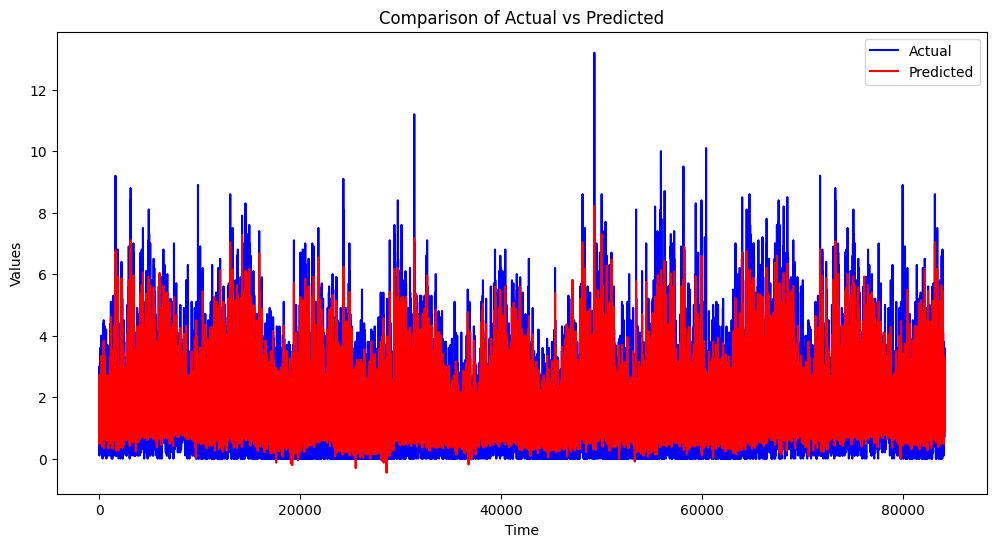

In [18]:
# Đánh giá mô hình trên tập kiểm tra
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics import mean_absolute_percentage_error

#loss = model.evaluate(X_test, y_test)
#print(f'Mean Squared Error on Test Data: {loss}')

# Tính toán sai số trung bình tuyệt đối và sai số bình phương trung bình
# Dự đoán trên tập kiểm tra
#y_pred = model.predict(X_test)

#mae = np.mean(np.abs(y_pred - y_test))
#mse = np.mean(np.square(y_pred - y_test))

#print("Mean Absolute Error (MAE):", mae)
#print("Mean Squared Error (MSE):", mse)

# Đảo ngược chuẩn hóa cho y_test và y_pred
#for i, column in enumerate(data.columns):
#    y_test[:, i] = scalers[column].inverse_transform(y_test[:, i].reshape(-1, 1)).reshape(-1)
#    y_pred[:, i] = scalers[column].inverse_transform(y_pred[:, i].reshape(-1, 1)).reshape(-1)
#import matplotlib.pyplot as plt
for i in range(y_test.shape[1]):
  plt.figure(figsize=(12, 6))
  plt.plot(y_test[:, i], color='blue', label='Actual')
  plt.plot(y_pred[:, i], color='red', label='Predicted')
  plt.title('Comparison of Actual vs Predicted')
  plt.xlabel('Time')
  plt.ylabel('Values')
  plt.legend()
  plt.show()


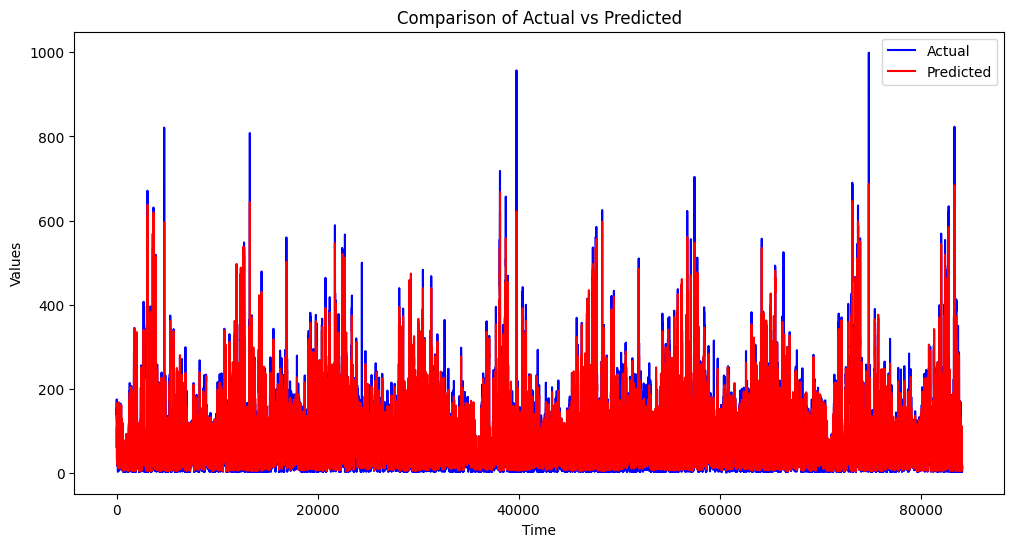

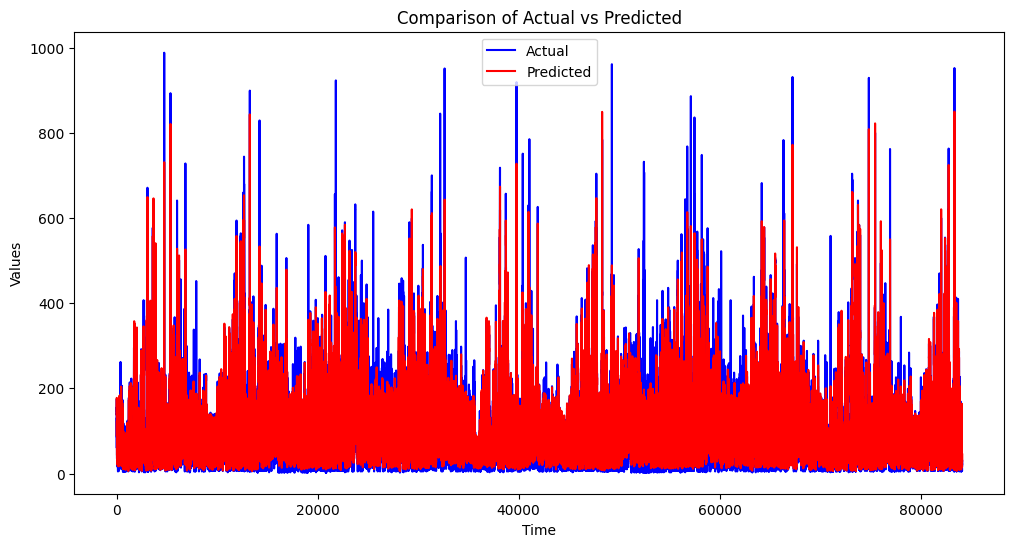

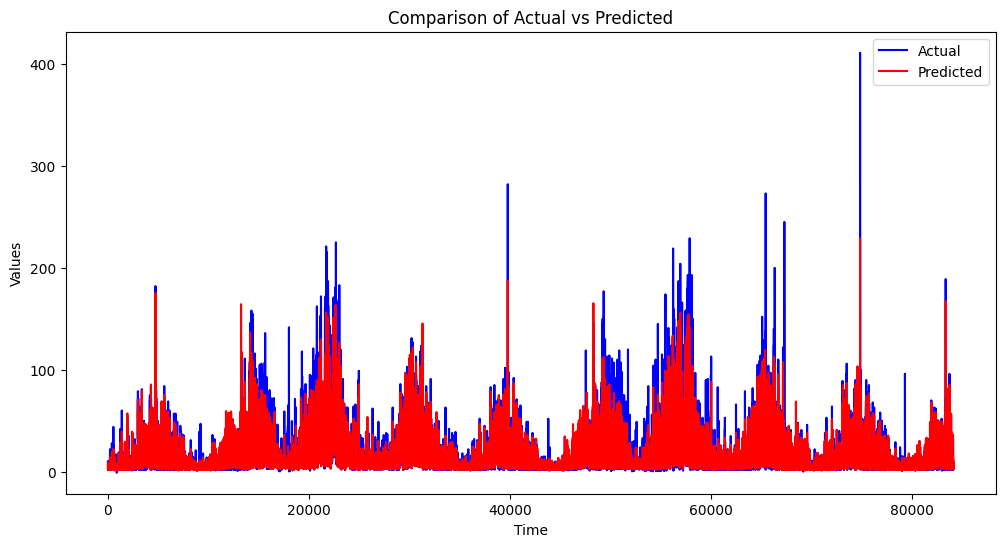

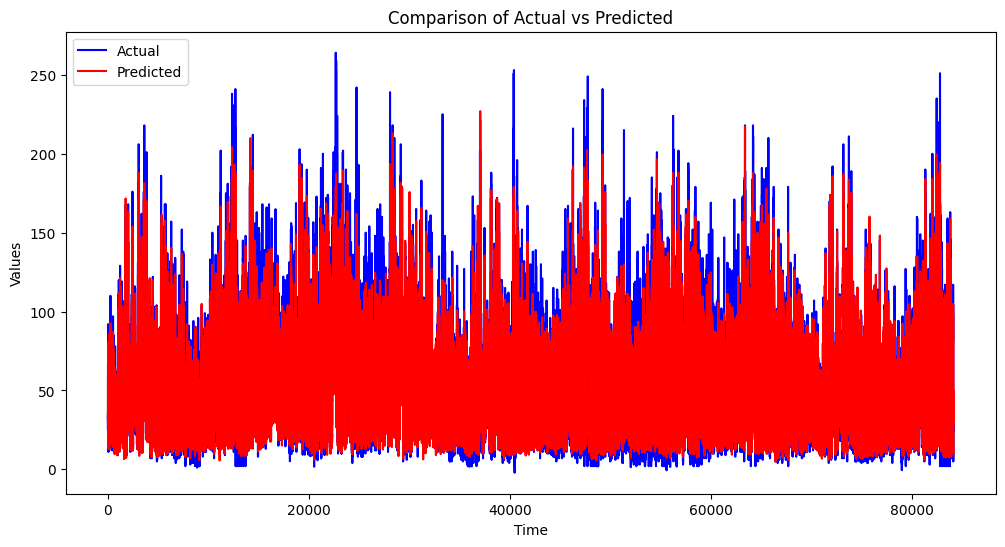

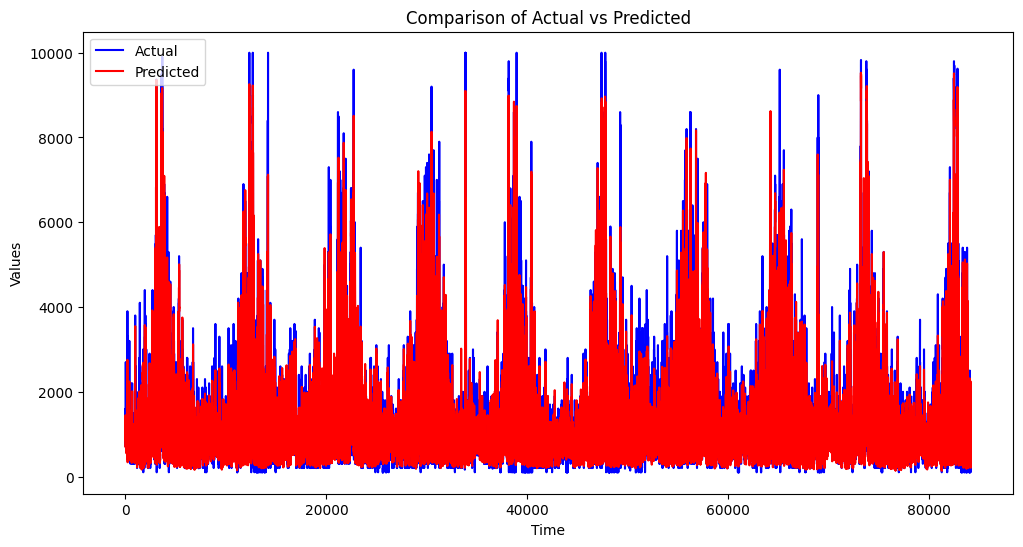

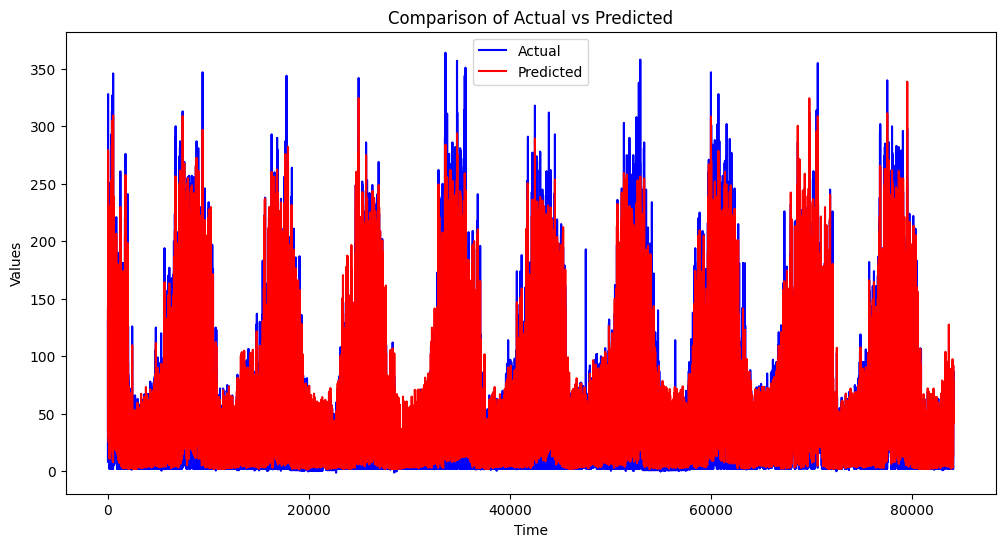

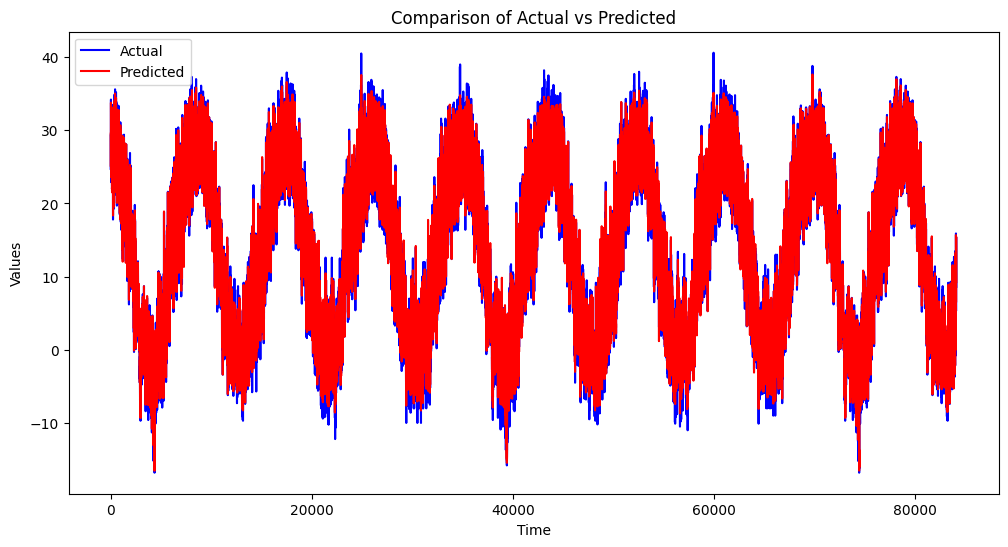

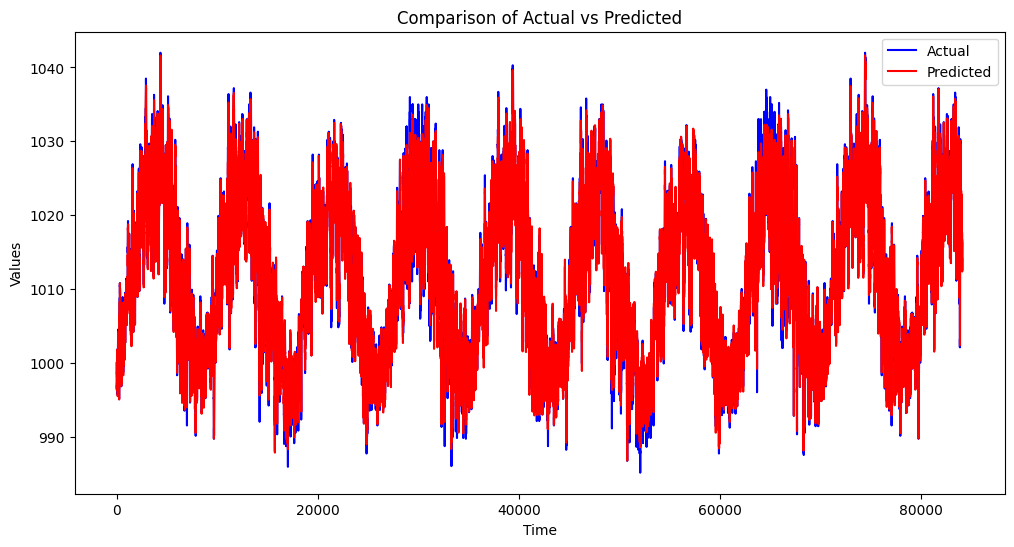

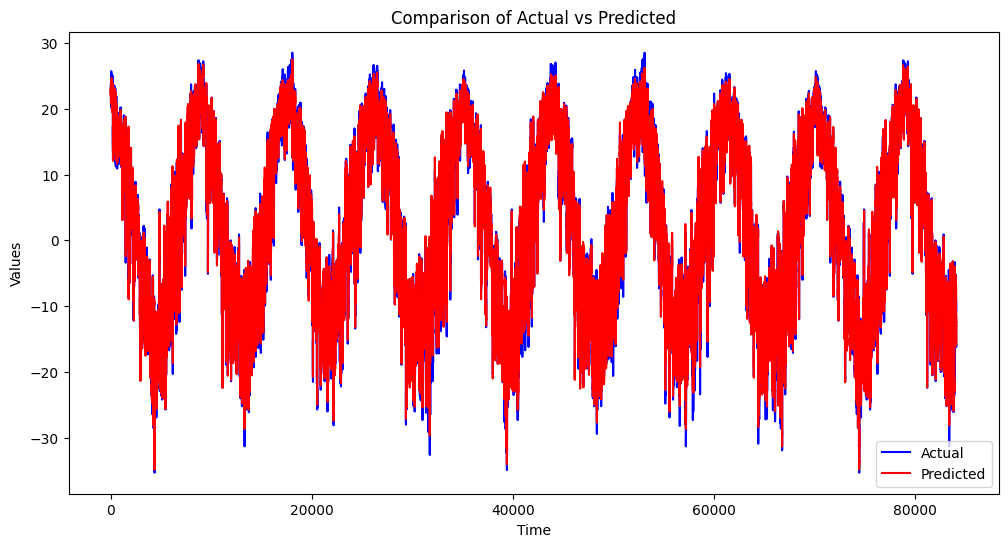

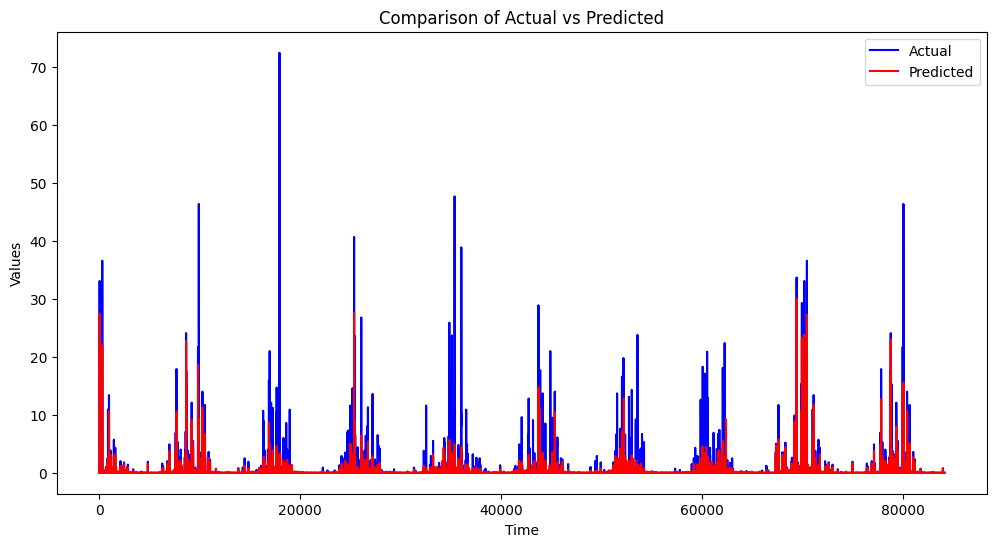

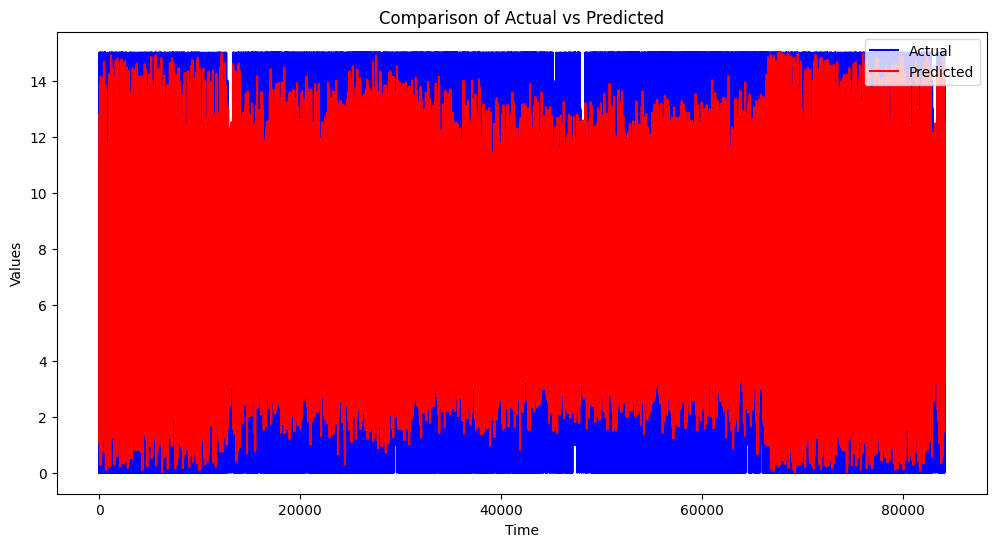

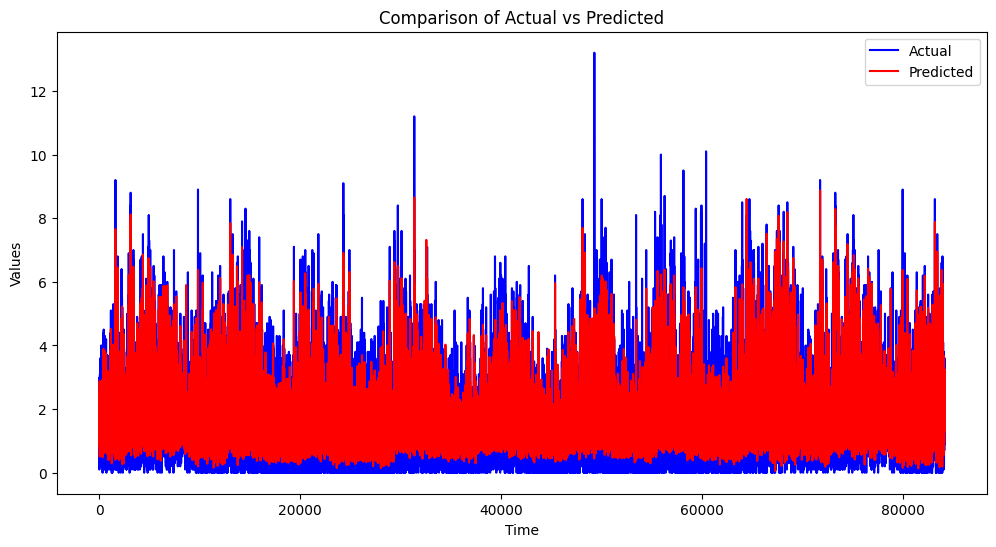

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics import mean_absolute_percentage_error


#loss = rfe.evaluate(X_test, y_test)
#print(f'Mean Squared Error on Test Data: {loss}')

# Tính toán sai số trung bình tuyệt đối và sai số bình phương trung bình
# Dự đoán trên tập kiểm tra
#y_pred2 = rfe.predict(testX_rf)

#mae = np.mean(np.abs(y_pred2 - y_test))
#mse = np.mean(np.square(y_pred2 - y_test))

#print("Mean Absolute Error (MAE):", mae)
#print("Mean Squared Error (MSE):", mse)

# Đảo ngược chuẩn hóa cho y_test và y_pred
#for i, column in enumerate(data.columns):
#    y_test[:, i] = scalers[column].inverse_transform(y_test[:, i].reshape(-1, 1)).reshape(-1)
#    y_pred2[:, i] = scalers[column].inverse_transform(y_pred2[:, i].reshape(-1, 1)).reshape(-1)
import matplotlib.pyplot as plt
for i in range(y_test.shape[1]):
  plt.figure(figsize=(12, 6))
  plt.plot(y_test[:, i], color='blue', label='Actual')
  plt.plot(y_pred2[:, i], color='red', label='Predicted')
  plt.title('Comparison of Actual vs Predicted')
  plt.xlabel('Time')
  plt.ylabel('Values')
  plt.legend()
  plt.show()